# Programa Ingenias+ Data Science

## Objetivo del proyecto

Predecir si una persona tendra hipertension alta o no, en base a sus habitos y/o condiciones socioeconomicas

## Objetivo del notebook

Este notebook tiene como objetivo probar diferentes algoritmos de clasificacion para determinar cual puede brindarnos mejores parametros. Nuestra variable objetivo sera 'mantiene_ha_alta' y las columnas de caracteristicas estan detalladas debajo.


## Importacion archivos y librerias

In [42]:
# imports de librerias y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,  OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from utils.codificaciones import *
from utils.funcions import *

In [3]:
# importo mi csv
friesgo = pd.read_csv('datasets/friesgo.csv')

# Preprocesado

Codificando las variables categoricas y eliminando los nan

In [4]:
# Primero busco cuales columnas efectivamente son categoricas y cuales numericas
variables_categoricas = ['cod_provincia','tamanio_aglomerado','sexo','condicion_actividad','ansiedad_depresion'
                           ,'nivel_actividad_fisica','condicion_fumador','consumo_sal'
                           ,'colesterol_alto','freq_cons_alc','es_diabetico','mantiene_ha_alta']
variables_numericas = ['edad','media_fv_diaria','imc_numerico']

In [5]:
# Creo una bd codificada a pesar de que ya esten codificados (para probar si algo cambia)
friesgo_cod = friesgo.copy()

In [6]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
id,0,0.0%
cod_provincia,0,0.0%
tamanio_aglomerado,0,0.0%
sexo,0,0.0%
edad,0,0.0%
condicion_actividad,0,0.0%
ansiedad_depresion,0,0.0%
nivel_actividad_fisica,226,0.84%
condicion_fumador,0,0.0%
mantiene_ha_alta,0,0.0%


In [7]:
friesgo_cod = friesgo_cod.dropna()

In [8]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
id,0,0.0%
cod_provincia,0,0.0%
tamanio_aglomerado,0,0.0%
sexo,0,0.0%
edad,0,0.0%
condicion_actividad,0,0.0%
ansiedad_depresion,0,0.0%
nivel_actividad_fisica,0,0.0%
condicion_fumador,0,0.0%
mantiene_ha_alta,0,0.0%


In [9]:
friesgo_cod.shape

(25539, 16)

In [10]:
# Codifico las columnas
le = LabelEncoder()
for columnas in variables_categoricas:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [11]:
friesgo_cod.mantiene_ha_alta.unique()

array([1, 0], dtype=int64)

In [12]:
friesgo_cod.shape

(25539, 16)

**Por ultimo, se realiza la division del modelo en train-test**

In [13]:
# Division del dataset en train-test en este caso el tamaño de la muestra sera del 30%
y = friesgo_cod['mantiene_ha_alta']
X = friesgo_cod.drop(columns=['mantiene_ha_alta'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Analisis modelos

### Modelo 0

## Modelo 1: Random Forest

In [17]:
# Como realice el preprocesado en la primera seccion, voy a crear un pipeline solo con el clasificador
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42,criterion= 'gini'))
])

In [18]:
# Creare tambien un diccionario con parametros para Gridsearch, que me ayudara a buscar los mejores parametros para mi modelo de modo mas rapido/automatizado
parametros = {
    'classifier__n_estimators': [150,200],
    'classifier__max_depth': [8,10],
    'classifier__min_samples_split': [2,4],
    'classifier__min_samples_leaf': [1] 
}

In [19]:
# Creo mi GridSearchCV
grid_search = GridSearchCV(pipeline, parametros, scoring='roc_auc',return_train_score = True,)

In [20]:
# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [8, 10],
                         'classifier__min_samples_leaf': [1],
                         'classifier__min_samples_split': [2, 4],
                         'classifier__n_estimators': [150, 200]},
             return_train_score=True, scoring='roc_auc')

In [27]:
#Guardo el modelo encontrado por gridsearch y que pude probar con mi notebook(sin que tarde 15min+)
mejor_modelo = grid_search.best_estimator_

In [35]:
matriz_conf

array([[1465, 1436],
       [ 705, 4056]], dtype=int64)

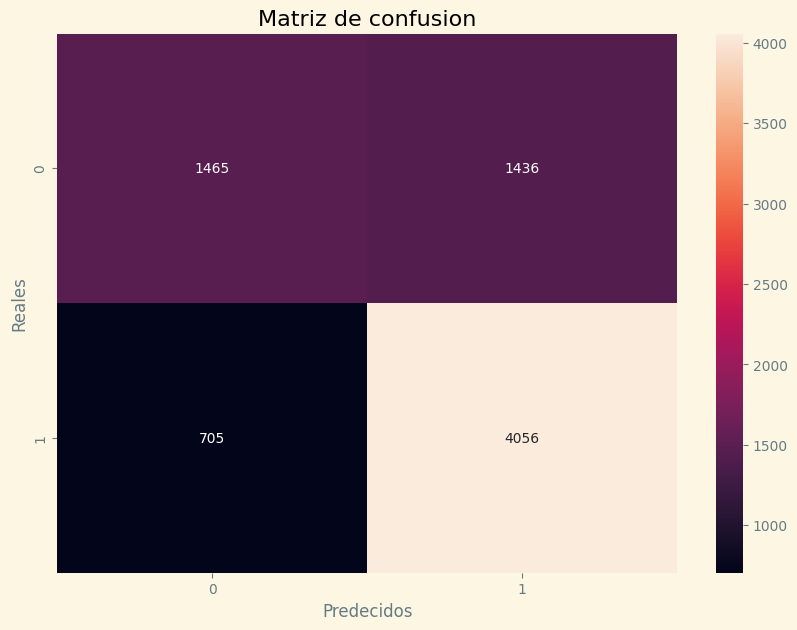

In [40]:
# Ahora de manera grafica 
matriz_conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_conf, annot=True, cmap='rocket', fmt='d')
plt.xlabel('Predecidos')
plt.ylabel('Reales')
plt.title('Matriz de confusion')
plt.show()

In [37]:
# Finalmente, evaluo el modelo viendo que tan bien predice mi variable objetivo, evaluandolo con el conjunto de datos de testeo
y_pred = mejor_modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.50      0.58      2901
           1       0.74      0.85      0.79      4761

    accuracy                           0.72      7662
   macro avg       0.71      0.68      0.68      7662
weighted avg       0.71      0.72      0.71      7662



In [25]:
# Creo una variable auxiliar para guardar las feature importances
feat = mejor_modelo.steps[0][1].feature_importances_

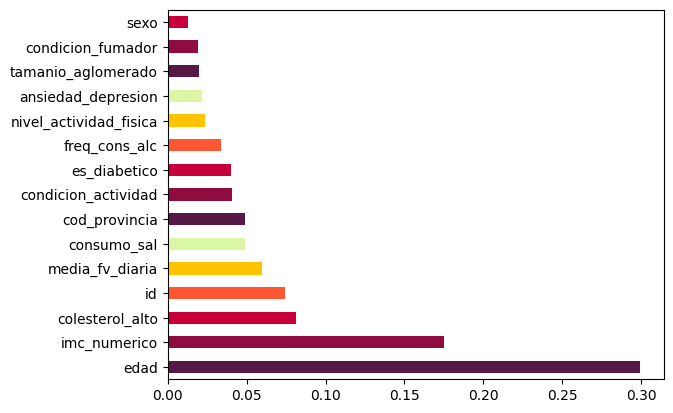

In [26]:
# Grafico las feature importances para saber cuales de mis caracteristicas seleccionadas tuvieron mas peso (a futuro podrian eliminarse aquellas que no para talvez optimizar los parametros)
feat_importances = pd.Series(feat , index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',  color=['#581845','#900C3F','#C70039','#FF5733','#FFC300','#DAF7A6'])
plt.style.use('Solarize_Light2')
plt.show()

Las etiquetas son para 'mantiene_ha_alta'
0:SI
1:NO

__En conclusion__ 

Tras evaluar una serie de parametros para este modelo y elegir el mejor obseramos:
+ El reporte de clasificacion (classification_report(y_test, y_pred)) nos indica que el modelo tiene una exactitud del 72% en la prediccion de nuevas etiquetas. Particularmente predice con una presicion del 68% las etiquetas correspondientes a la clase 0 (mantiene hipertension alta) y con una presicion del 74% para las correspondientes a clase 1 (no mantiene hipertension alta), entonces podria decirse que este modelo funciona mejor para predecir a aquellos individuos que efectivamente no tienen hipertencion arterial alta.
+ El grafico de la matriz de confusion nos indica que: 

    + 705 casos fueron predichos como 0(hipertensos) cuando eran 1(no hipertensos) 
    + 1436 casos fueron predecidos como 1(no hipertensos) cuando eran 0(hipertensos)
    + 1465 casos fueron predecidos como 0(hipertensos) cuando eran 0(hipertensos)
    + 4056 casos fueron predecidos como 1(no hipertensos) cuando eran 1(no hipertensos)

Entonces, solo el 50% de aquellos etiquetados como hipertensos fueron etiquetados correctamente, mientras que el 85% de los etiquetados como no hipertensos fue etiquetado correctamente.

+ Feature importance, las caracteristicas que mas parecen importar para el modelo durante la clasificacion son: la edad, el imc, si tiene colesterol alto y el consumo de frutas y verduras diarias. (4/5 son variables numericas)

In [38]:
friesgo_cod.shape

(25539, 16)

In [51]:
pd.Series(y_pred).value_counts()

1    5492
0    2170
Name: count, dtype: int64

In [49]:
y_test.value_counts()

mantiene_ha_alta
1    4761
0    2901
Name: count, dtype: int64

## Modelo 2